# Process hourly data to daily

In [3]:
import xarray as xr

In [2]:
# Path to era5 hourly data
era_path = "/g/data/rt52/era5/single-levels/reanalysis/"

We can open a single netcdf file, which has one month of data, using `xr.open_dataset`. To open multiple files at once, we can use `xr.open_mfdataset`, using regex to specify which files in a directory we want.

### Opening multiple files simultaneously

Let's open all months from the year 1959 for 2m temperature:

In [4]:
year = 1959

First define the file path. We use `era_path` as assigned above to keep the code short. We also convert our chosen year to a string. Finally, we use the regular expression asterisk with the netcdf file extension (`*.nc`) to select all netcdf files in that directory.

In [7]:
fp = era_path + "2t/" + str(year) + "/*.nc"
print(fp)

/g/data/rt52/era5/single-levels/reanalysis/2t/1959/*.nc


In [8]:
temp = xr.open_mfdataset(fp)

In [9]:
temp

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1959-01-01 ... 1959-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-13 03:13:16 UTC+1000 by era5_replication_tools-1.11...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 19590101-19590131

You can see from the print out above that we now have every hour in 1959, for the entire globe.

This is quite a lot of data, and we can check how many GB this dataset is:

In [10]:
temp.nbytes / 1024 ** 3

33.88152301684022

33GB is quite large, especially if we want to look at many years.

### Preprocess

Let's say we are interested in a single grid cell. The most efficient way to open the data for a single cell is to pass the `preprocess` argument in `open_mfdataset'.

Let's define a function that selects a grid cell:

In [11]:
def select_cell(ds):
    """
    Selects a cell from a dataset.
    """
    return ds.sel(latitude=34, longitude=-117)

Now pass `select_cell` to `open_mfdataset`:

In [12]:
temp = xr.open_mfdataset(fp, preprocess=select_cell)

In [13]:
temp

<xarray.Dataset>
Dimensions:    (time: 8760)
Coordinates:
    longitude  float32 -117.0
    latitude   float32 34.0
  * time       (time) datetime64[ns] 1959-01-01 ... 1959-12-31T23:00:00
Data variables:
    t2m        (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-13 03:13:16 UTC+1000 by era5_replication_tools-1.11...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 19590101-19590131

In [14]:
temp.nbytes / 1024 ** 3

9.790807962417603e-05

Now this file size is tiny!

### Open for all years

We're going to define a function that will take a variable name, a set of years and value of latitude and longitude than will open all desired data. Defining a function will save us copying, pasting and editing the code for each variable we want.

So that we can change which latitude/longitude we want, we will redefine the `select_cell` function within this new function.

In [35]:
def read_data(var_name, years, latitude, longitude, path):
    """
    Read data for a set of years and a single grid cell.
    
    var_name: string, the variable name e.g. 2t, 10u
    years: range, the years you want to open e.g. range(2000, 2010)
    latitude, longitude: int or float, the grid cell you want to read
    path: string, the path to the data. For era reanalysis this would be /g/data/rt52/era5/single-levels/reanalysis/
    """
    
    # Define the preprocess  function
    def select_cell(ds):
        return ds.sel(latitude=latitude, longitude=longitude)
    
    # Set up an empty list
    ds_list = []
    for year in years: # Loop through years
        # Set the filepath
        fp = path + var_name + "/" + str(year) + "/*.nc"
        
        # Open all files in this year for one grid cell
        ds = xr.open_mfdataset(fp, preprocess=select_cell)
        
        # append to list
        ds_list.append(ds)
        
    # Concatenate all years along time
    ds_concat = xr.concat(ds_list, dim="time")
    
    return ds_concat

Let's open all temperature data between 2000 and 2022 for the same grid cell as before

In [36]:
variable = "2t"
years = range(2000, 2023)
lat = 34
lon = -117

Now open using our function

In [37]:
temp = read_data(
    var_name=variable,
    years=years,
    latitude=lat,
    longitude=lon,
    path=era_path
)

In [38]:
temp

<xarray.Dataset>
Dimensions:    (time: 201624)
Coordinates:
    longitude  float32 -117.0
    latitude   float32 34.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

In [34]:
temp.nbytes / 1024 ** 3

9.389594197273254e-05

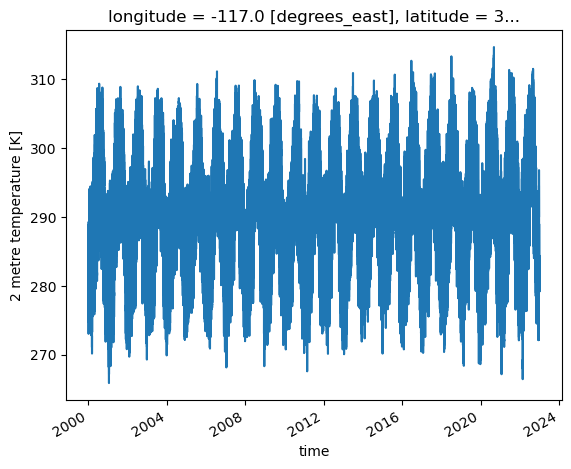

In [29]:
# note that plotting takes a while
temp.t2m.plot()

All you need to do to open a different variable is to change the variable name in `read_data`. Likewise for different latitude or longitudes.

For example `read_data("10u", years, lat, lon, era_path)` would open all horizontal wind at 10m data.

You can also open mulitple lat/lons by using `slice`. To get a region between 110-120W and 35-40N, you could pass `latitude=slice(40, 35)` and `longitude=slice(-120, -110)`

# Resampling

Often, we want to look at our data at a different resolution than it is stored at. If we want daily ERA5 data, we have to resample from hourly resolution. This is acheived using `xarray`'s `resample`:

We pass the argument `time="1D"`, which tells `xarray` to resample along the `time` dimension to daily, and this is followed by `.mean()`, which gives us the daily average.

In [39]:
temp_daily = temp.resample(time="1D").mean()

In [40]:
temp_daily

<xarray.Dataset>
Dimensions:    (time: 8401)
Coordinates:
    longitude  float32 -117.0
    latitude   float32 34.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2022-12-31
Data variables:
    t2m        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

Other options include resampling to multiple days e.g. `resample(time="3D")`, or to months `resample(time="1MS")`. Note that ERA5 already has monthly data, so no need to do this!

You can also obtain resampled sums, not averages, by using `.sum()` instead of `.mean()`.

A final note is that, if you want to, you could do the resampling when you open the files in `mfdataset` by editing the function that you pass as `preprocess`.

At this point, you might want to write the data so you don't have to go through this process again:

In [42]:
# temp_daily.to_netcdf(path_to_write_to)